![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/legal-nlp/09.1.Entity_Resolution_Edgar_unique_IDs.ipynb)

# Installation

In [ ]:
! pip install -q johnsnowlabs

## Automatic Installation
Using my.johnsnowlabs.com SSO

In [ ]:
from johnsnowlabs import nlp, legal

# nlp.install(force_browser=True)

## Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to my.johnsnowlabs.com
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

- Install it

In [ ]:
nlp.install()

# Starting

In [ ]:
spark = nlp.start()

# Legal Entity Resolution: unique IDs


Entity resolution is an important task in natural language processing and information extraction, as it allows for more accurate analysis and understanding of legal texts. For example, in a news article discussing the performance of a company's stock, accurately identifying and disambiguating the company's name is crucial for accurately tracking the stock's performance.

An NLP use case in financial or legal applications is identifying legal entities' presence in a given text. One of those entities could be `Company Name`. We can carry out NER to extract different chunks of information, but in real financial and legal use cases, the company name is usually not useful as it is mentioned in the text. Sometimes we need the **_official_** name of the company (instead of `Amazon`, `Amazon.com INC`, as registered in Edgar, Crunchbase and Nasdaq). We have pre-trained sentence entity resolver models for these purposes shown below with the examples.

## Retrieving unique IDs

Besides mapping a series of non-normalized strings to a normalized version of, for example, the company name in some registries, we can also map them to retrieve unique IDs (as IRS id in Edgar database) using Entity Resolution.

Let's take a look at how we do it.

## Pretrained Entity Resolution Models for Legal

Here are the list of pretrained Entity Resolution models:

|index|model|
|-----:|:-----|
| 1| [Company Name Normalization Using Edgar Database](https://nlp.johnsnowlabs.com/2022/08/30/legel_edgar_company_name_en.html)  |
| 2| [Company Names Normalization Using Crunchbase](https://nlp.johnsnowlabs.com/2022/08/09/legel_crunchbase_companynames_en_3_2.html)  | 
| 3| [Company Name to IRS (Edgar database)](https://nlp.johnsnowlabs.com/2022/08/30/finel_edgar_company_name_en.html)  |


## Common Componennts


Other than providing the code in the "result" field it provides more metadata about the matching process:

- target_text -> Text to resolve
- resolved_text -> Best match text
- confidence -> Relative confidence for the top match (distance to probability)
- confidence_ratio -> Relative confidence for the top match. TopMatchConfidence / SecondMatchConfidence
- alternative_codes -> List of other plausible codes (in the KNN neighborhood)
- all_k_resolutions -> All codes descriptions
- all_k_results -> All resolved codes for metrics calculation purposes
- sentence -> SentenceId

We will use following Generic Function For Getting the Codes and Relation Pairs

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', 0)

def get_codes (lp, text, vocab='company_name', hcc=False):

    """Returns LightPipeline resolution results"""
    
    full_light_result = lp.fullAnnotate(text)

    chunks = []
    codes = []
    begin = []
    end = []
    resolutions=[]
    all_distances =[]
    all_codes=[]
    all_cosines = []
    all_k_aux_labels=[]

    for i in range(len(full_light_result)):

      for chunk, code in zip(full_light_result[i]['ner_chunk'], full_light_result[i][vocab]):   
          begin.append(chunk.begin)
          end.append(chunk.end)
          chunks.append(chunk.result)
          codes.append(code.result) 
          all_codes.append(code.metadata['all_k_results'].split(':::'))
          resolutions.append(code.metadata['all_k_resolutions'].split(':::'))
          all_distances.append(code.metadata['all_k_distances'].split(':::'))
          all_cosines.append(code.metadata['all_k_cosine_distances'].split(':::'))
          if hcc:
              try:
                  all_k_aux_labels.append(code.metadata['all_k_aux_labels'].split(':::'))
              except:
                  all_k_aux_labels.append([])
          else:
              all_k_aux_labels.append([])

    df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 'code':codes, 'all_codes':all_codes, 
                       'resolutions':resolutions, 'all_k_aux_labels':all_k_aux_labels,'all_distances':all_cosines})
    
    return df

### Normalized Name
In Edgar, the company official is different! We need to take it before being able to augment with external information in EDGAR.

- Incorrect: `Contact Gold`
- Correct (Official): `Contact Gold Corp`

## Find Company IRS Number

An employer identification number (EIN) is a nine-digit number assigned by the `IRS`. It's used to identify the tax accounts of employers and certain others who have no employees. The IRS uses the number to identify taxpayers who are required to file various business tax returns. EINs are used by employers, sole proprietors, corporations, partnerships, non-profit associations, trusts, estates of decedents, government agencies, certain individuals, and other business entities.



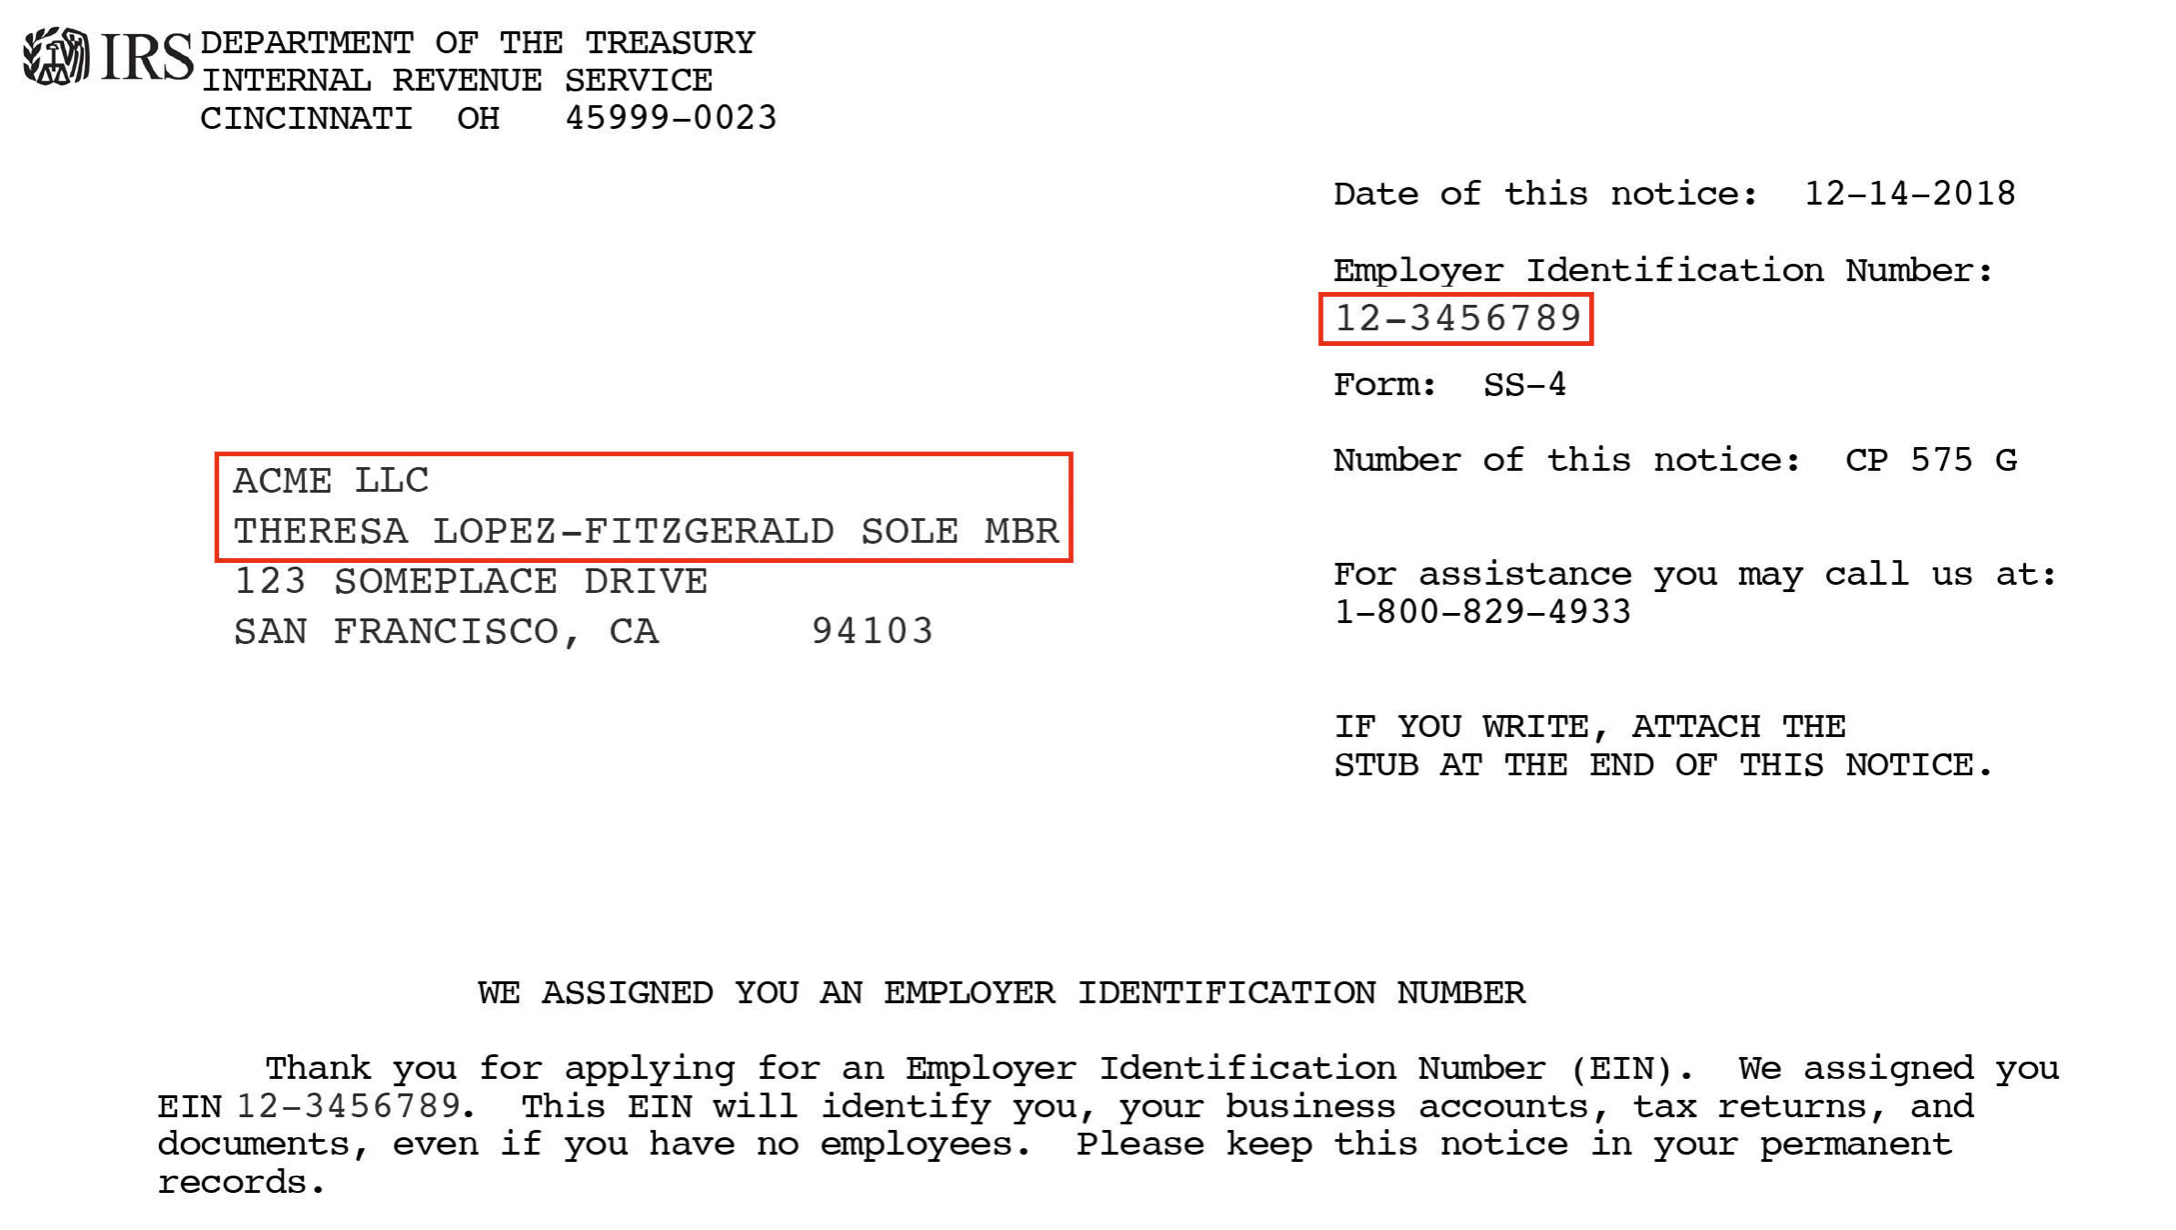

In [ ]:
NORM_ORG = 'Contact Gold Corp'

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk")

embeddings = nlp.UniversalSentenceEncoder.pretrained("tfhub_use", "en") \
      .setInputCols("ner_chunk") \
      .setOutputCol("sentence_embeddings")

resolver = legal.SentenceEntityResolverModel.pretrained("legel_edgar_irs", "en", "legal/models") \
      .setInputCols(["sentence_embeddings"]) \
      .setOutputCol("irs_code")\
      .setDistanceFunction("EUCLIDEAN")

pipelineModel = nlp.PipelineModel(
      stages = [
          documentAssembler,
          embeddings,
          resolver])

lp = nlp.LightPipeline(pipelineModel)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
legel_edgar_irs download started this may take some time.
[OK!]


In [ ]:
%time 
get_codes (lp, NORM_ORG, vocab='irs_code')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs


chunks  begin  end       code  \
0  Contact Gold Corp  0      16   981369960   

                                                                          all_codes  \
0  [981369960, 223386947, 261918920, 760594911, 392060052, 0, 841473173, 202805440]   

                                                                        resolutions  \
0  [981369960, 223386947, 261918920, 760594911, 392060052, 0, 841473173, 202805440]   

  all_k_aux_labels  \
0  []                

                                                      all_distances  
0  [0.0000, 0.1380, 0.1388, 0.1402, 0.1406, 0.1456, 0.1497, 0.1528]